In [104]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
# import kagglehub
# clmentbisaillon_fake_and_real_news_dataset_path = kagglehub.dataset_download('clmentbisaillon/fake-and-real-news-dataset')

# print('Data source import complete.')


# Fake/Real News torch RoBERTa+PEFT

https://www.kaggle.com/code/stpeteishii/twitch-reviews-torch-roberta


## About PEFT
PEFT (Parameter-Efficient Fine-Tuning) is a technique used in machine learning, particularly in the context of fine-tuning large pre-trained models like transformers (e.g., BERT, GPT, etc.) for specific tasks. The primary goal of PEFT is to reduce the number of parameters that need to be updated during the fine-tuning process, which significantly decreases the computational cost and memory usage while maintaining or even improving performance.

## Key Concepts of PEFT:
Efficiency: By focusing only on a subset of parameters, PEFT avoids the need to fine-tune all parameters of the model, making the process faster and less resource-intensive.

Memory and Computational Savings: PEFT drastically reduces the amount of GPU memory required, making it feasible to fine-tune very large models on smaller hardware setups.

Performance Maintenance: Despite fine-tuning fewer parameters, PEFT techniques are often able to achieve comparable or even superior performance to full fine-tuning.

Application Areas: PEFT is widely used in natural language processing (NLP), computer vision, and other AI tasks that involve large-scale models, allowing for efficient adaptation of general-purpose models to specific applications.

## Techniques Used in PEFT:
Adapters: Small neural network modules inserted into the layers of a pre-trained model that learn task-specific information without altering the main model weights.

Low-Rank Adaptation (LoRA): A method that fine-tunes low-rank updates to the model weights, reducing the number of parameters that need to be trained.

Prefix Tuning: Adds task-specific vectors (prefixes) to the input sequence that influence the model output, thus adapting the model without changing its core parameters.

BitFit (Bias-Only Fine-Tuning): Fine-tunes only the bias terms of the model, leaving the majority of the weights untouched.



In [105]:
!pip install peft

In [106]:
!pip install chardet

In [107]:
debug = False
debug2 = False

In [108]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import transformers
import random
import chardet
import warnings
warnings.simplefilter('ignore')
scaler = torch.cuda.amp.GradScaler()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [109]:
def random_seed(SEED):

    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

SEED = 508
random_seed(SEED)

In [110]:
fake=pd.read_csv('sampled_fake.csv')
fake['label']='fake'
true=pd.read_csv('sampled_true.csv')
true['label']='true'
data=pd.concat([fake[['label','text']],true[['label','text']]],axis=0).reset_index(drop=True)
n=len(data)
N=list(range(n))
random.shuffle(N)
data=data.iloc[N]
display(data)

,label,text
6158,true,NEW YORK (Reuters) - The race to succeed Repub...
6843,true,SEOUL (Reuters) - North Korea used Chinese-mad...
3224,fake,A group of people beat a man in a Brooklyn res...
4212,true,ROME (Reuters) - Italy s anti-establishment 5-...
390,fake,Communism begins where atheism begins. -Karl ...
...,...,...
4053,true,WELLINGTON (Reuters) - A final tally in New Ze...
3437,fake,As usual Milwaukee s outspoken Sheriff David C...
5436,true,WASHINGTON (Reuters) - When President Donald T...
6441,true,JAKARTA (Reuters) - Indonesia s speaker of par...


In [111]:
data.columns=['label','text']
class_names=sorted(data['label'].unique().tolist())
print(class_names)
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N))
reverse_mapping=dict(zip(N,class_names))
data['label']=data['label'].map(normal_mapping)

['fake', 'true']


In [112]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data[0:3000], test_size=0.2, random_state=42)

In [113]:
#tokenizer = transformers.BertTokenizer.from_pretrained("../input/bert-base-uncased")
tokenizer = transformers.RobertaTokenizer.from_pretrained("roberta-base")

In [114]:
test_s = train['text'].iloc[0]

result1 = tokenizer.encode_plus(test_s)

tokenizer.decode(result1["input_ids"])

'<s>The gay mafia has a new corporate  Don. This is the only article you will need to read about the sheer stupidity of left-wing agitators who are crowing about the new religious freedom law in Indiana.Yesterday, Apple CEO Tim Cook, himself a gay man, published an op-ed in The Washington Post with this ominous title:  Pro-discrimination laws are dangerous.  Cook argues that religious freedom laws, like the one signed by Gov. Mike Pence of Indiana last week are  dangerous  to gay people.A debatable point. However, what is not debatable is this: laws that make homosexuality punishable by death are dangerous to gay people.That s why you might be surprised to learn that Cook s company, Apple, does business in four (4) countries that make homosexuality a capital crime. Those countries are Saudi Arabia, the United Arab Emirates, Nigeria, and Qatar.If you zip on over to this page, you can see the list of all of the countries where Apple does business. Those four countries are on the list.We 

In [115]:
len(test_s.split(" "))

215

In [116]:
result2 = tokenizer.encode_plus(
    test_s,
    add_special_tokens = True,
    max_length = 32,
    pad_to_max_length = True,
    truncation = True
)

In [117]:
tokenizer.decode(result2["input_ids"])

'<s>The gay mafia has a new corporate  Don. This is the only article you will need to read about the sheer stupidity of left-wing agit</s>'

In [118]:
max_sens = 32

train = train.sort_values("label").reset_index(drop=True)

train["kfold"] = train.index % 5

p_train = train[train["kfold"]!=0].reset_index(drop=True)
p_valid = train[train["kfold"]==0].reset_index(drop=True)

p_test=test.reset_index(drop=True)

'token_type_ids' no need in RoBERTa/DeBERTa

In [119]:
class BERTDataSet(Dataset):

    def __init__(self,sentences,targets):
        self.sentences = sentences
        self.targets = targets

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self,idx):
        sentence = self.sentences[idx]
        bert_sens = tokenizer.encode_plus(
                                sentence,
                                add_special_tokens = True,
                                max_length = max_sens,
                                pad_to_max_length = True,
                                return_attention_mask = True)

        ids = torch.tensor(bert_sens['input_ids'], dtype=torch.long)
        mask = torch.tensor(bert_sens['attention_mask'], dtype=torch.long)

        target = torch.tensor(self.targets[idx],dtype=torch.float)

        return {
                'ids': ids,
                'mask': mask,

                'targets': target
            }

In [120]:
train_dataset = BERTDataSet(p_train["text"],p_train["label"])
valid_dataset = BERTDataSet(p_valid["text"],p_valid["label"])
test_dataset = BERTDataSet(p_test["text"],p_test["label"])

train_batch = 16
valid_batch = 32
test_batch = 32

train_dataloader = DataLoader(train_dataset,batch_size=train_batch,shuffle = True,num_workers=8,pin_memory=True)
valid_dataloader = DataLoader(valid_dataset,batch_size=valid_batch,shuffle = False,num_workers=8,pin_memory=True)
test_dataloader = DataLoader(test_dataset,batch_size=test_batch,shuffle = False,num_workers=8,pin_memory=True)

In [121]:
model = transformers.RobertaForSequenceClassification.from_pretrained("roberta-base",num_labels=1)
#model = transformers.BertForSequenceClassification.from_pretrained("../input/bert-base-uncased",num_labels=1)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# peft setting for roberta

In [122]:
#peft setting for roberta

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1
)

lora_model = get_peft_model(model, lora_config)
model = lora_model
display(model)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [123]:
model.to(device)
model.train()

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [124]:
for a in train_dataloader:
    ids = a["ids"].to(device)
    mask = a["mask"].to(device)

    output = model(ids,mask)
    break

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [125]:
output = output["logits"].squeeze(-1).shape

In [126]:
from torch.optim import AdamW
LR=2e-5
optimizer = AdamW(model.parameters(), LR,betas=(0.9, 0.999), weight_decay=1e-2)

# set epochs

In [127]:
from transformers import get_linear_schedule_with_warmup
epochs = 20
if debug:
    epochs = 1
train_steps = int(len(p_train)/train_batch*epochs)
print(train_steps)
num_steps = int(train_steps*0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

2400


In [128]:
def loss_fn(output,target):
    return torch.sqrt(nn.MSELoss()(output,target))

# def training

In [129]:
def training(
    train_dataloader,
    model,
    optimizer,
    scheduler
):

    model.train()
    torch.backends.cudnn.benchmark = True
    allpreds = []
    alltargets = []

    for a in train_dataloader:

        losses = []
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():

            ids = a["ids"].to(device,non_blocking=True)
            mask = a["mask"].to(device,non_blocking=True)

            output = model(ids,mask)
            output = output["logits"].squeeze(-1)
            target = a["targets"].to(device,non_blocking=True)
            loss = loss_fn(output,target)

            losses.append(loss.item())
            allpreds.append(output.detach().cpu().numpy())
            alltargets.append(target.detach().squeeze(-1).cpu().numpy())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        del loss

        scheduler.step()

    allpreds = np.concatenate(allpreds)
    alltargets = np.concatenate(alltargets)
    losses = np.mean(losses)
    train_rme_loss = np.sqrt(mean_squared_error(alltargets,allpreds))

    return losses,train_rme_loss

# def validating

In [130]:
def validating(valid_dataloader,model):

    model.eval()
    allpreds = []
    alltargets = []

    for a in valid_dataloader:
        losses = []
        with torch.no_grad():

            ids = a["ids"].to(device)
            mask = a["mask"].to(device)

            output = model(ids,mask)
            output = output["logits"].squeeze(-1)
            target = a["targets"].to(device)
            loss = loss_fn(output,target)
            losses.append(loss.item())
            allpreds.append(output.detach().cpu().numpy())
            alltargets.append(target.detach().squeeze(-1).cpu().numpy())

            del loss

    allpreds = np.concatenate(allpreds)
    alltargets = np.concatenate(alltargets)
    losses = np.mean(losses)
    valid_rme_loss = np.sqrt(mean_squared_error(alltargets,allpreds))

    return allpreds,losses,valid_rme_loss

In [131]:
if debug2 == False:
    for a in range(epochs):
        for b in train_dataloader:
            break

    losses,train_rme_loss = training(train_dataloader,model,optimizer,scheduler)

    for a in valid_dataloader:
        break

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

# Train and Validate

In [132]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

trainlosses = []
vallosses = []
bestscore = None
trainscores = []
validscores = []

for epoch in tqdm(range(epochs)):

    print("---------------" + str(epoch) + "start-------------")

    trainloss,trainscore = training(train_dataloader,model,optimizer,scheduler)
    trainlosses.append(trainloss)
    trainscores.append(trainscore)

    print("trainscore is " + str(trainscore))

    preds,validloss,valscore=validating(valid_dataloader,model)
    vallosses.append(validloss)
    validscores.append(valscore)
    print(f"Validation Loss: {validloss:.4f}, Validation Score (RMSE): {valscore:.4f}")

    # 计算额外的性能指标
    preds_binary = (preds > 0.5).astype(int)  # 将预测值转换为二进制标签
    true_labels = p_valid['label'].values  # 验证集真实标签


    eval_accuracy = accuracy_score(true_labels, preds_binary)
    eval_precision = precision_score(true_labels, preds_binary, zero_division=0)
    eval_recall = recall_score(true_labels, preds_binary, zero_division=0)
    eval_f1 = f1_score(true_labels, preds_binary, zero_division=0)

    print("valscore is " + str(valscore))
    print(f"Validation Accuracy: {eval_accuracy:.4f}")
    print(f"Validation Precision: {eval_precision:.4f}")
    print(f"Validation Recall: {eval_recall:.4f}")
    print(f"Validation F1 Score: {eval_f1:.4f}")

    if bestscore is None:
        bestscore = valscore

        print("Save first model")

        state = {
                        'state_dict': model.state_dict(),
                        'optimizer_dict': optimizer.state_dict(),
                        "bestscore":bestscore
                    }

        torch.save(state, "model0.pth")

    elif bestscore > valscore:

        bestscore = valscore
        print("found better point")
        state = {
                        'state_dict': model.state_dict(),
                        'optimizer_dict': optimizer.state_dict(),
                        "bestscore":bestscore
                    }

        torch.save(state, "model0.pth")

    else:
        pass

        # 打印性能指标为 JSON 格式
    metrics = {
        "eval_loss": validloss,
        "eval_accuracy": eval_accuracy,
        "eval_precision": eval_precision,
        "eval_recall": eval_recall,
        "eval_f1": eval_f1,
        "eval_runtime": None,  # 可选：记录运行时间
        "eval_samples_per_second": None,  # 可选：记录每秒处理的样本数
        "eval_steps_per_second": None,  # 可选：记录每秒处理的步骤数
        "epoch": epoch + 1
    }
    print(f"Metrics for Epoch {epoch + 1}: {metrics}")


  0%|          | 0/20 [00:00<?, ?it/s]

---------------0start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.5028074245540494


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.3332, Validation Score (RMSE): 0.3629
valscore is 0.36285566196431784
Validation Accuracy: 0.9979
Validation Precision: 1.0000
Validation Recall: 0.9959
Validation F1 Score: 0.9980
Save first model


  5%|▌         | 1/20 [00:21<06:39, 21.01s/it]

Metrics for Epoch 1: {'eval_loss': np.float64(0.3332133889198303), 'eval_accuracy': 0.9979166666666667, 'eval_precision': 1.0, 'eval_recall': 0.9959183673469387, 'eval_f1': 0.9979550102249489, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 1}
---------------1start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.2677514705092211


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.1325, Validation Score (RMSE): 0.0901
valscore is 0.09008966356305842
Validation Accuracy: 0.9979
Validation Precision: 1.0000
Validation Recall: 0.9959
Validation F1 Score: 0.9980
found better point


 10%|█         | 2/20 [00:42<06:21, 21.20s/it]

Metrics for Epoch 2: {'eval_loss': np.float64(0.1325242966413498), 'eval_accuracy': 0.9979166666666667, 'eval_precision': 1.0, 'eval_recall': 0.9959183673469387, 'eval_f1': 0.9979550102249489, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 2}
---------------2start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.19417022464081843


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.1638, Validation Score (RMSE): 0.1213
valscore is 0.12132359042416872
Validation Accuracy: 0.9979
Validation Precision: 1.0000
Validation Recall: 0.9959
Validation F1 Score: 0.9980
Metrics for Epoch 3: {'eval_loss': np.float64(0.16378329694271088), 'eval_accuracy': 0.9979166666666667, 'eval_precision': 1.0, 'eval_recall': 0.9959183673469387, 'eval_f1': 0.9979550102249489, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 3}
---------------3start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.163211939442655


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.1778, Validation Score (RMSE): 0.1257
valscore is 0.12568412519815358
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000
Metrics for Epoch 4: {'eval_loss': np.float64(0.17775848507881165), 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 4}
---------------4start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.14802524765992864


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.2369, Validation Score (RMSE): 0.1667
valscore is 0.16669940937301742
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000
Metrics for Epoch 5: {'eval_loss': np.float64(0.23691719770431519), 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 5}
---------------5start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.1385762059268855


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.2326, Validation Score (RMSE): 0.1665
valscore is 0.16646096019697273
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000
Metrics for Epoch 6: {'eval_loss': np.float64(0.23259595036506653), 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 6}
---------------6start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.13046281424171416


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.1717, Validation Score (RMSE): 0.1202
valscore is 0.12024211976958608
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000
Metrics for Epoch 7: {'eval_loss': np.float64(0.17168231308460236), 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 7}
---------------7start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.12048326702941717


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.1602, Validation Score (RMSE): 0.1121
valscore is 0.11209337007273684
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000
Metrics for Epoch 8: {'eval_loss': np.float64(0.16023989021778107), 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 8}
---------------8start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.11773746899650862


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.1853, Validation Score (RMSE): 0.1321
valscore is 0.13210495945360165
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000
Metrics for Epoch 9: {'eval_loss': np.float64(0.1852950155735016), 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 9}
---------------9start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.11614409696310277


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.1155, Validation Score (RMSE): 0.0769
valscore is 0.0769169479136932
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000
found better point


 50%|█████     | 10/20 [03:18<03:21, 20.15s/it]

Metrics for Epoch 10: {'eval_loss': np.float64(0.11545626074075699), 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 10}
---------------10start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.11500968687578401


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.1287, Validation Score (RMSE): 0.0871
valscore is 0.08706901164685409
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000
Metrics for Epoch 11: {'eval_loss': np.float64(0.12872791290283203), 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 11}
---------------11start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.10935792193596776


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.1334, Validation Score (RMSE): 0.0904
valscore is 0.09039897500147778
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000
Metrics for Epoch 12: {'eval_loss': np.float64(0.13341699540615082), 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 12}
---------------12start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.11083341571468983


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.1222, Validation Score (RMSE): 0.0836
valscore is 0.08364946378212097
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000
Metrics for Epoch 13: {'eval_loss': np.float64(0.12220436334609985), 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 13}
---------------13start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.10723325903015989


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.1291, Validation Score (RMSE): 0.0904
valscore is 0.0904425022858084
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000
Metrics for Epoch 14: {'eval_loss': np.float64(0.12914417684078217), 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 14}
---------------14start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.1049940011817098


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.1229, Validation Score (RMSE): 0.0851
valscore is 0.08510221322032435
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000
Metrics for Epoch 15: {'eval_loss': np.float64(0.12286948412656784), 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 15}
---------------15start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.10259794179635913


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.1359, Validation Score (RMSE): 0.0958
valscore is 0.09581955328203969
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000
Metrics for Epoch 16: {'eval_loss': np.float64(0.135904923081398), 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 16}
---------------16start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.10355324781230806


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.1205, Validation Score (RMSE): 0.0835
valscore is 0.08350769040515192
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000
Metrics for Epoch 17: {'eval_loss': np.float64(0.1205160841345787), 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 17}
---------------17start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.10412315910436204


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.1237, Validation Score (RMSE): 0.0862
valscore is 0.08624984052719356
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000
Metrics for Epoch 18: {'eval_loss': np.float64(0.12366215884685516), 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 18}
---------------18start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.09958904657308552


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.1248, Validation Score (RMSE): 0.0871
valscore is 0.08714216549564884
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000
Metrics for Epoch 19: {'eval_loss': np.float64(0.12482305616140366), 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 19}
---------------19start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.10250776812437097


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Validation Loss: 0.1248, Validation Score (RMSE): 0.0871
valscore is 0.08714216549564884
Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000
Metrics for Epoch 20: {'eval_loss': np.float64(0.12482305616140366), 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': None, 'eval_samples_per_second': None, 'eval_steps_per_second': None, 'epoch': 20}


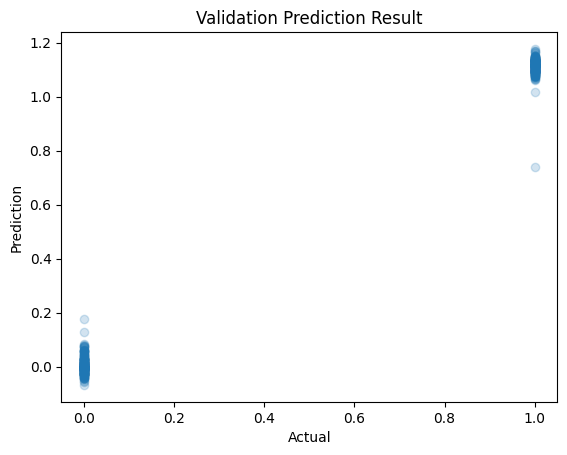

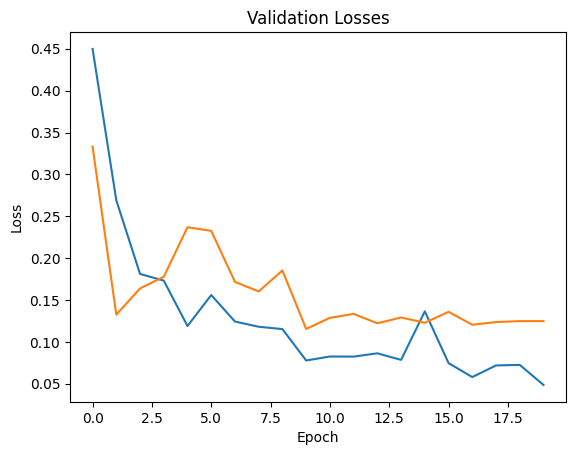

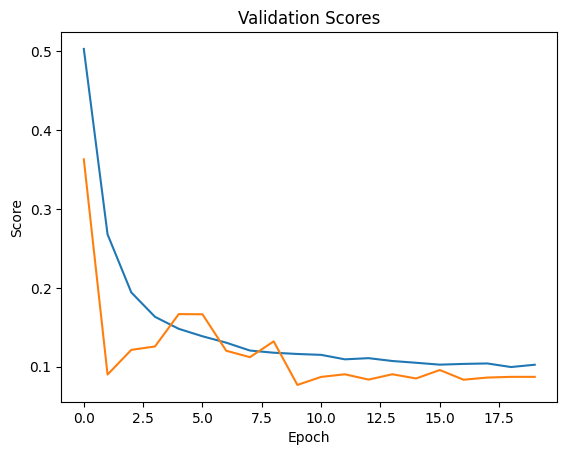

In [133]:
plt.scatter(p_valid['label'],preds, alpha=0.2)
plt.title('Validation Prediction Result')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

x = np.arange(epochs)
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trainlosses)
plt.plot(x,vallosses)
plt.show()

x = np.arange(epochs)
plt.title('Validation Scores')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.plot(x,trainscores)
plt.plot(x,validscores)
plt.show()

# save model

    bestscores = []
    bestscores.append(bestscore)

    for fold in range(1,5):

        # initializing the data
        p_train = train[train["kfold"]!=fold].reset_index(drop=True)
        p_valid = train[train["kfold"]==fold].reset_index(drop=True)

        train_dataset = BERTDataSet(p_train["text"],p_train["label"])
        valid_dataset = BERTDataSet(p_valid["text"],p_valid["label"])

        train_dataloader = DataLoader(train_dataset,batch_size=train_batch,shuffle = True,num_workers=4,pin_memory=True)
        valid_dataloader = DataLoader(valid_dataset,batch_size=valid_batch,shuffle = False,num_workers=4,pin_memory=True)

        model = transformers.RobertaForSequenceClassification.from_pretrained("roberta-base",num_labels=1)

        model.to(device)
        LR=2e-5
        optimizer = AdamW(model.parameters(), LR,betas=(0.9, 0.999), weight_decay=1e-2) # AdamW optimizer
        train_steps = int(len(p_train)/train_batch*epochs)
        num_steps = int(train_steps*0.1)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

        trainlosses = []
        vallosses = []
        bestscore = None
        trainscores = []
        validscores = []

        for epoch in tqdm(range(epochs)):

            print("---------------" + str(epoch) + "start-------------")

            trainloss,trainscore = training(train_dataloader,model,optimizer,scheduler)
            trainlosses.append(trainloss)
            trainscores.append(trainscore)

            print("trainscore is " + str(trainscore))

            preds,validloss,valscore=validating(valid_dataloader,model)
            vallosses.append(validloss)
            validscores.append(valscore)

            print("valscore is " + str(valscore))

            if bestscore is None:
                bestscore = valscore

                print("Save first model")

                state = {
                                'state_dict': model.state_dict(),
                                'optimizer_dict': optimizer.state_dict(),
                                "bestscore":bestscore
                            }

                torch.save(state, "model" + str(fold) + ".pth")

            elif bestscore > valscore:
                bestscore = valscore
                print("found better point")

                state = {
                                'state_dict': model.state_dict(),
                                'optimizer_dict': optimizer.state_dict(),
                                "bestscore":bestscore
                            }
                torch.save(state, "model"+ str(fold) + ".pth")

            else:
                pass


        bestscores.append(bestscore)

    bestscores

    np.mean(bestscores)
    print("my cv is " + str(np.mean(bestscores)))

# def predicting
not use saved models

In [134]:
def predicting(test_dataloader,model):

    model.to(device)
    model.eval()
    allpreds = []
    preds = []
    allvalloss=0

    with torch.no_grad():
        for a in test_dataloader:

            ids = a["ids"].to(device)
            mask = a["mask"].to(device)

            output = model(ids,mask)
            output = output["logits"].squeeze(-1)
            preds.append(output.cpu().numpy())

        preds = np.concatenate(preds)
        allpreds.append(preds)

    return allpreds

# def predicting2
use saved models

    #model initialized
    model = transformers.RobertaForSequenceClassification.from_pretrained("roberta-base",num_labels=1)

    pthes = [os.path.join("./",s) for s in os.listdir("./") if ".pth" in s]

    def predicting2(
        test_dataloader,
        model,
        pthes
    ):

        allpreds = []    
        for pth in pthes:

            state = torch.load(pth)        
            model.load_state_dict(state["state_dict"])
            model.to(device)
            model.eval()      
            preds = []
            allvalloss=0

            with torch.no_grad():

                for a in test_dataloader:

                    ids = a["ids"].to(device)
                    mask = a["mask"].to(device)

                    output = model(ids,mask)
                    output = output["logits"].squeeze(-1)
                    preds.append(output.cpu().numpy())

                preds = np.concatenate(preds)           
                allpreds.append(preds)

        return allpreds

# Predict

In [135]:
tpreds = predicting(test_dataloader,model)
#tpreds = predicting2(test_dataloader,model,pthes)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

# Prediction Result

In [136]:
test_pred = []
for p in tpreds[0]:
    test_pred+=[p]

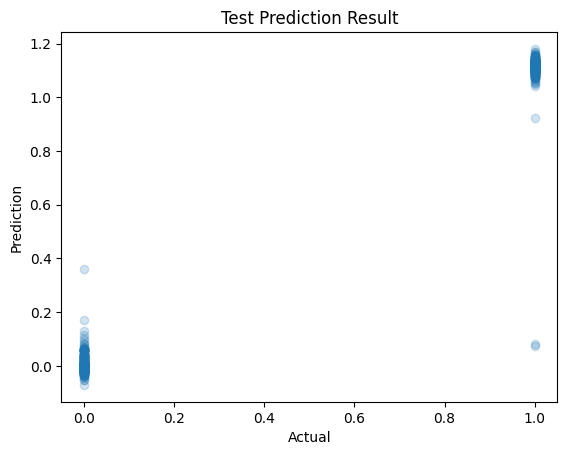

In [137]:
plt.scatter(p_test['label'],test_pred, alpha=0.2)
plt.title('Test Prediction Result')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()